## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [23]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2021-11-26 19:41:10--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2021-11-26 19:41:11--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce19102147e51a3efaf92d4861c.dl.dropboxusercontent.com/cd/0/inline/BaumPiSz399VWsc4ZgwJlbfxluW4eG4i6DaZPq62Qd7R6Jjl9tQ15ZGF1Aj20CzrfPV_tylGNWwoWcvJSrbpdOQN_bHMHe3esJvrghumNZpG-6WmP9PLqy1BmVNz0VT8idb5bxEcrCeMnOM1M3QxKXpt/file# [following]
--2021-11-26 19:41:12--  https://uce19102147e51a3efaf92d4861c.dl.dropboxusercontent.com/cd/0/inline/BaumPiSz399VWsc4ZgwJlbfxluW4eG4i6DaZPq62Qd7R6Jjl9tQ15ZGF1Aj20CzrfPV_tylGNWwoWc

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [35]:
import numpy as np
import pandas as pd
from random import randint

file_name = "data_000637.txt"
N=randint(10000,1310719)
print('the number of rows is',N)
# mode can be specified for writing, reading or both
with open(file_name, mode='r') as f:
       dfs3 = pd.read_csv(f,nrows=N)

df = pd.DataFrame(dfs3)
df[40:70]

the number of rows is 257711


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
40,1,0,54,3869200167,3184,28
41,1,0,56,3869200167,3177,20
42,1,0,57,3869200167,3187,17
43,1,1,1,3869200168,7,18
44,1,0,64,3869200168,7,16
45,1,1,1,3869200168,13,18
46,1,0,63,3869200168,8,28
47,1,1,2,3869200168,17,26
48,1,0,139,3869200168,23,0
49,1,0,61,3869200168,18,17


In [36]:
#the period of Bx_counter is each 3563(at least it is the max we can detect). 
number_x=df['BX_COUNTER'].max()
print(number_x)

3563


In [37]:
from datetime import datetime

now = datetime.now()
with open(file_name, mode='r') as f:
       dfs3 = pd.read_csv(f,nrows=1310719)
now2 = datetime.now()
print(now2-now)

0:00:00.386384


In [38]:
df['absolute_time']=df['TDC_CHANNEL']*(25/30)+df['BX_COUNTER']*25+df['ORBIT_CNT']*3563*25
df.head(10)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute_time
0,1,0,123,3869200167,2374,26,3.446490e+14
1,1,0,124,3869200167,2374,27,3.446490e+14
2,1,0,63,3869200167,2553,28,3.446490e+14
3,1,0,64,3869200167,2558,19,3.446490e+14
4,1,0,64,3869200167,2760,25,3.446490e+14
5,1,0,63,3869200167,2762,4,3.446490e+14
6,1,0,61,3869200167,2772,14,3.446490e+14
7,1,0,139,3869200167,2776,0,3.446490e+14
8,1,0,62,3869200167,2774,21,3.446490e+14
9,1,0,60,3869200167,2788,7,3.446490e+14


In [39]:
df['HEAD']=np.random.randint(2, size=N)
df.head(20)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute_time
0,0,0,123,3869200167,2374,26,3.446490e+14
1,1,0,124,3869200167,2374,27,3.446490e+14
2,1,0,63,3869200167,2553,28,3.446490e+14
3,1,0,64,3869200167,2558,19,3.446490e+14
4,1,0,64,3869200167,2760,25,3.446490e+14
5,1,0,63,3869200167,2762,4,3.446490e+14
6,1,0,61,3869200167,2772,14,3.446490e+14
7,0,0,139,3869200167,2776,0,3.446490e+14
8,1,0,62,3869200167,2774,21,3.446490e+14
9,1,0,60,3869200167,2788,7,3.446490e+14


In [40]:
New_df = df[df['HEAD']==1]
New_df.head(20)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute_time
1,1,0,124,3869200167,2374,27,3.446490e+14
2,1,0,63,3869200167,2553,28,3.446490e+14
3,1,0,64,3869200167,2558,19,3.446490e+14
4,1,0,64,3869200167,2760,25,3.446490e+14
5,1,0,63,3869200167,2762,4,3.446490e+14
6,1,0,61,3869200167,2772,14,3.446490e+14
8,1,0,62,3869200167,2774,21,3.446490e+14
9,1,0,60,3869200167,2788,7,3.446490e+14
10,1,1,7,3869200167,2785,4,3.446490e+14
11,1,0,64,3869200167,2786,19,3.446490e+14


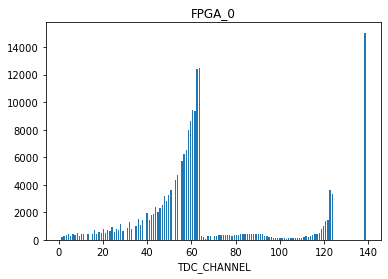

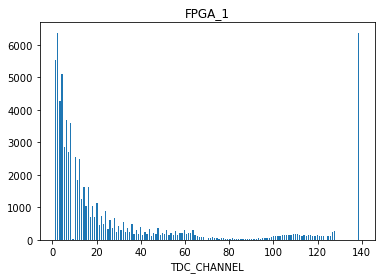

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl

df0=df[df['FPGA']==0]
df1=df[df['FPGA']==1]

bins=140

plt.hist(df0['TDC_CHANNEL'] ,bins=bins, rwidth=0.6)
plt.xlabel('TDC_CHANNEL',size=10)
plt.title('FPGA_0')
plt.show()

plt.hist(df1['TDC_CHANNEL'] ,bins=bins, rwidth=0.6)
plt.xlabel('TDC_CHANNEL',size=10)
plt.title('FPGA_1')

plt.show()


In [42]:
noisy_df=df.groupby('TDC_CHANNEL').count()
noisy_df.nlargest(3,'absolute_time')   # or each column's name!

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute_time
TDC_CHANNEL,,,,,,
139,21420,21420,21420,21420,21420,21420
64,12826,12826,12826,12826,12826,12826
63,12589,12589,12589,12589,12589,12589


In [43]:
#for fpga 0
noisy_df0=df0.groupby('TDC_CHANNEL').count()
noisy_df0.nlargest(3,'absolute_time')  

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute_time
TDC_CHANNEL,,,,,,
139,15047,15047,15047,15047,15047,15047
64,12523,12523,12523,12523,12523,12523
63,12386,12386,12386,12386,12386,12386


In [44]:
#for fpga 1
noisy_df1=df1.groupby('TDC_CHANNEL').count()
noisy_df1.nlargest(3,'absolute_time')  

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute_time
TDC_CHANNEL,,,,,,
139,6373,6373,6373,6373,6373,6373
2,6358,6358,6358,6358,6358,6358
1,5535,5535,5535,5535,5535,5535


In [45]:
odf=df.groupby('ORBIT_CNT').count()
print('Number of Unique orbits:',odf.shape[0])

tdf=df[df["TDC_CHANNEL"]==139]
tdf2=tdf.groupby('ORBIT_CNT').count()
print('Number of unique orbits with at least one measurement from TDC_CHANNEL=139: ',tdf2.shape[0])

Number of Unique orbits: 2562
Number of unique orbits with at least one measurement from TDC_CHANNEL=139:  2557
